In [60]:
import datetime
import os
import random

import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.utils import save_image

manualSeed = 10001
random.seed(manualSeed)
torch.manual_seed(manualSeed)

In [61]:
import multiprocessing
data = "/media/disc/img_align_celeba/a/"
output_dir="output/"
if output_dir.endswith("/"):
    output_dir=output_dir[:-1]
stat_output='stat-output/'
if stat_output.endswith("/"):
    stat_output=stat_output[:-1]
model_output="model"
if model_output.endswith("/"):
    model_output=model_output[:-1]

if not os.path.exists(output_dir):
    os.makedirs(output_dir)
if not os.path.exists(stat_output):
    os.makedirs(stat_output)
if not os.path.exists(model_output):
    os.makedirs(model_output)

cpu_count = multiprocessing.cpu_count()
batch_size = 128
image_size = 64
num_epochs = 5
learning_rate = 0.0002

In [62]:
dataset = datasets.ImageFolder(root=data,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
number_of_images=len(dataset)
loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=cpu_count)
device = torch.device("cuda:0")

In [63]:
def weights_initialization(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [66]:
from network_model.discriminator import Discriminator
from network_model.generator import  Generator
discriminator = Discriminator().cuda()
discriminator.apply(weights_initialization)
generator = Generator().cuda()
generator.apply(weights_initialization)

print(f"Generator summary:\n {generator}")
print(f"Discriminator summary:\n {discriminator}")

Generator summary:
 Generator(
  (generator): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False

In [67]:
loss = nn.BCELoss()
optimizer_discriminator = optim.Adam(discriminator.parameters(), lr=learning_rate, betas=(0.5, 0.999))
optimizer_generator = optim.Adam(generator.parameters(), lr=learning_rate, betas=(0.5, 0.999))

In [68]:
generator_losses = []
discriminator_losses = []
iterations = 0
generator_noise = torch.randn(64, 100, 1, 1, device=device)

number_of_batches=len(loader)
with open(os.path.join(stat_output,f"stat-{str(datetime.datetime.now()).replace(' ','-')}.txt"),"w+") as file:
    for epoch in range(num_epochs):
        for i, data in enumerate(loader, 0):
            discriminator.zero_grad()
            real_image = data[0].to(device)
            epoch_batch_size = real_image.size(0)
            labels = torch.full((epoch_batch_size,), 1, dtype=torch.float, device=device)
            output = discriminator(real_image).view(-1)
            discriminator_error_real = loss(output, labels)
            discriminator_error_real.backward()
            discriminator_real_mean = output.mean().item()

            noise = torch.randn(epoch_batch_size,
            100, 1, 1, device=device)
            fake_image = generator(noise)
            labels=torch.full((epoch_batch_size,), 0, dtype=torch.float, device=device)
            output = discriminator(fake_image.detach()).view(-1)
            error_discriminator_fake = loss(output, labels)
            error_discriminator_fake.backward()
            generator_mean = output.mean().item()
            error_discriminator = discriminator_error_real + error_discriminator_fake
            optimizer_discriminator.step()
            generator.zero_grad()
            labels = torch.full((epoch_batch_size,), 1, dtype=torch.float, device=device)
            output = discriminator(fake_image).view(-1)
            error_generator = loss(output, labels)
            error_generator.backward()
            discriminator_fake_mean = output.mean().item()
            optimizer_generator.step()

            if i%50==0:
                file.write('[%d/%d][%d/%d]\tDiscriminator loss: %.4f\tGenerator loss: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f\n'
                  % (epoch, num_epochs, i, number_of_batches,
                     error_discriminator.item(), error_generator.item(), discriminator_real_mean, generator_mean, discriminator_fake_mean))
                print('[%d/%d][%d/%d]\tDiscriminator loss: %.4f\tGenerator loss: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, number_of_batches,
                     error_discriminator.item(), error_generator.item(), discriminator_real_mean, generator_mean, discriminator_fake_mean))

            generator_losses.append(error_generator.item())
            discriminator_losses.append(error_discriminator.item())

            if (iterations % 500 == 0) or ((epoch == num_epochs-1) and (i == number_of_batches-1)):
                with torch.no_grad():
                    fake=generator(generator_noise)[0]
                    save_image(fake,f'{output_dir}/image-{epoch}-{iterations}.jpg')
            iterations += 1

[0/5][0/1333]	Discriminator loss: 1.3181	Generator loss: 6.1578	D(x): 0.6314	D(G(z)): 0.4762 / 0.0030
[0/5][50/1333]	Discriminator loss: 0.2153	Generator loss: 30.7304	D(x): 0.9037	D(G(z)): 0.0000 / 0.0000
[0/5][100/1333]	Discriminator loss: 2.3947	Generator loss: 20.1895	D(x): 0.9747	D(G(z)): 0.8138 / 0.0000
[0/5][150/1333]	Discriminator loss: 0.7046	Generator loss: 6.4770	D(x): 0.8497	D(G(z)): 0.3329 / 0.0039
[0/5][200/1333]	Discriminator loss: 0.6375	Generator loss: 6.5326	D(x): 0.6530	D(G(z)): 0.0033 / 0.0030
[0/5][250/1333]	Discriminator loss: 0.2816	Generator loss: 5.1573	D(x): 0.9100	D(G(z)): 0.1518 / 0.0093
[0/5][300/1333]	Discriminator loss: 0.4092	Generator loss: 4.3969	D(x): 0.9400	D(G(z)): 0.2597 / 0.0321
[0/5][350/1333]	Discriminator loss: 0.4027	Generator loss: 3.1983	D(x): 0.7613	D(G(z)): 0.0721 / 0.0640
[0/5][400/1333]	Discriminator loss: 0.4160	Generator loss: 3.2906	D(x): 0.8416	D(G(z)): 0.1742 / 0.0576
[0/5][450/1333]	Discriminator loss: 1.2101	Generator loss: 4.3749

Exception in thread QueueFeederThread:
Traceback (most recent call last):
  File "/home/mihael/miniconda3/envs/master-project/lib/python3.7/multiprocessing/queues.py", line 224, in _feed
    nwait()
  File "/home/mihael/miniconda3/envs/master-project/lib/python3.7/multiprocessing/connection.py", line 177, in close
    self._close()
  File "/home/mihael/miniconda3/envs/master-project/lib/python3.7/multiprocessing/connection.py", line 361, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/mihael/miniconda3/envs/master-project/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/home/mihael/miniconda3/envs/master-project/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/home/mihael/miniconda3/envs/master-project/lib/python3.7/multiprocessing/queues.py", line 224, in _f

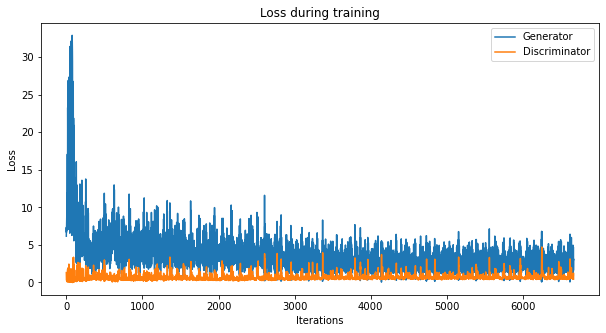

In [69]:
plt.figure(figsize=(10,5))
plt.title("Loss during training")
plt.plot(generator_losses,label="Generator")
plt.plot(discriminator_losses,label="Discriminator")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.savefig(f"{output_dir}/results.png")
plt.show()

In [70]:
torch.save(discriminator.state_dict(), f"{model_output}/model-discriminator.txt")
torch.save(generator.state_dict(), f"{model_output}/model-generator.txt")